In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=1059b5830c7db8694fdb4090fed565c7a05ef85555fce504362c112be2e54df8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
# Load Data
df = spark.read.csv("Dataset.csv", header=True, inferSchema=True)
df = df.dropna()
# df = spark.read.option("inferSchema", "True").csv("Dataset.csv", header=True)
df.show()

+---+--------------------+--------+----------+-----+-------------+
| id|         sugar_level|calories|    weight|  fat|   food_color|
+---+--------------------+--------+----------+-----+-------------+
|  1|145.7699999999999...| 764 cal|1745.73 gr|46 gr| Lemon Yellow|
|  2|-4.60000000000000...| 262 cal|1903.09 gr|24 gr|    Navy Blue|
|  3|            95.81 gr| 448 cal|1539.14 gr|27 gr|Sunset Yellow|
|  4|           100.16 gr| 375 cal| 746.22 gr|11 gr|Sunset Yellow|
|  5|-8.56000000000000...|  93 cal| 134.08 gr|26 gr|   Sunset Red|
|  6|           140.24 gr| 651 cal|1989.74 gr|24 gr|       Purple|
|  7|35.26000000000000...| 331 cal|1994.42 gr|32 gr|    Navy Blue|
|  8|            35.47 gr| 245 cal| 438.82 gr|28 gr|        Green|
|  9|59.76000000000000...| 771 cal|  31.05 gr|24 gr|       Coffee|
| 10|-7.60999999999999...|  99 cal|  157.4 gr| 4 gr|       Purple|
| 11|96.58000000000001 gr| 506 cal|  169.6 gr|26 gr|Sunset Yellow|
| 12|5.180000000000007 gr| 459 cal| 169.26 gr|19 gr|   Sunset 

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- sugar_level: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- weight: string (nullable = true)
 |-- fat: string (nullable = true)
 |-- food_color: string (nullable = true)



In [ ]:
# Select Feature (As requested from the question)
df = df.select("sugar_level", "calories", "weight", "fat", "food_color")

df = df.withColumn("sugar_level", regexp_extract("sugar_level", r"(\d+)", 1))
df = df.withColumn("sugar_level", col("sugar_level").cast(FloatType()))

df = df.withColumn("calories", regexp_extract("calories", r"(\d+)", 1))
df = df.withColumn("calories", col("calories").cast(FloatType()))

df = df.withColumn("weight", regexp_extract("weight", r"(\d+)", 1))
df = df.withColumn("weight", col("weight").cast(FloatType()))

df = df.withColumn("fat", regexp_extract("fat", r"(\d+)", 1))
df = df.withColumn("fat", col("fat").cast(FloatType()))

In [ ]:
df = df.withColumn("food_color", when(df["food_color"] == "Black", 0).
                   when(df["food_color"] == "Coffee", 1).
                   when(df["food_color"] == "Grass Green", 2).
                   when(df["food_color"] == "Green", 3).
                   when(df["food_color"] == "Lemon Yellow", 4).
                   when(df["food_color"] == "Navy Blue", 5).
                   when(df["food_color"] == "Purple", 6).
                   when(df["food_color"] == "Rose", 7).
                   when(df["food_color"] == "Sunset Red", 8).
                   when(df["food_color"] == "Sunset Yellow", 9))

df.show()

+-----------+--------+------+----+----------+
|sugar_level|calories|weight| fat|food_color|
+-----------+--------+------+----+----------+
|      145.0|   764.0|1745.0|46.0|         4|
|        4.0|   262.0|1903.0|24.0|         5|
|       95.0|   448.0|1539.0|27.0|         9|
|      100.0|   375.0| 746.0|11.0|         9|
|        8.0|    93.0| 134.0|26.0|         8|
|      140.0|   651.0|1989.0|24.0|         6|
|       35.0|   331.0|1994.0|32.0|         5|
|       35.0|   245.0| 438.0|28.0|         3|
|       59.0|   771.0|  31.0|24.0|         1|
|        7.0|    99.0| 157.0| 4.0|         6|
|       96.0|   506.0| 169.0|26.0|         9|
|        5.0|   459.0| 169.0|19.0|         8|
|      100.0|   346.0|1296.0|15.0|         0|
|      116.0|   436.0| 539.0|36.0|         9|
|       86.0|   312.0|1122.0|38.0|         3|
|      142.0|   430.0| 228.0|36.0|         4|
|       97.0|   262.0| 245.0|31.0|         7|
|      150.0|   384.0|1414.0|19.0|         4|
|      137.0|   679.0|1127.0|44.0|

In [ ]:
# Normalization with VectorAssembler and StandardScaler
df = VectorAssembler(inputCols=df.columns, outputCol="VectorOut").transform(df)
df = StandardScaler(inputCol="VectorOut", outputCol="features").fit(df).transform(df)

df.show()

+-----------+--------+------+----+----------+--------------------+--------------------+
|sugar_level|calories|weight| fat|food_color|           VectorOut|            features|
+-----------+--------+------+----+----------+--------------------+--------------------+
|      145.0|   764.0|1745.0|46.0|         4|[145.0,764.0,1745...|[3.16585848810440...|
|        4.0|   262.0|1903.0|24.0|         5|[4.0,262.0,1903.0...|[0.08733402725805...|
|       95.0|   448.0|1539.0|27.0|         9|[95.0,448.0,1539....|[2.07418314737874...|
|      100.0|   375.0| 746.0|11.0|         9|[100.0,375.0,746....|[2.18335068145131...|
|        8.0|    93.0| 134.0|26.0|         8|[8.0,93.0,134.0,2...|[0.17466805451610...|
|      140.0|   651.0|1989.0|24.0|         6|[140.0,651.0,1989...|[3.05669095403184...|
|       35.0|   331.0|1994.0|32.0|         5|[35.0,331.0,1994....|[0.76417273850796...|
|       35.0|   245.0| 438.0|28.0|         3|[35.0,245.0,438.0...|[0.76417273850796...|
|       59.0|   771.0|  31.0|24.

In [ ]:
model = KMeans().setK(2)
prediction = model.fit(df).transform(df)

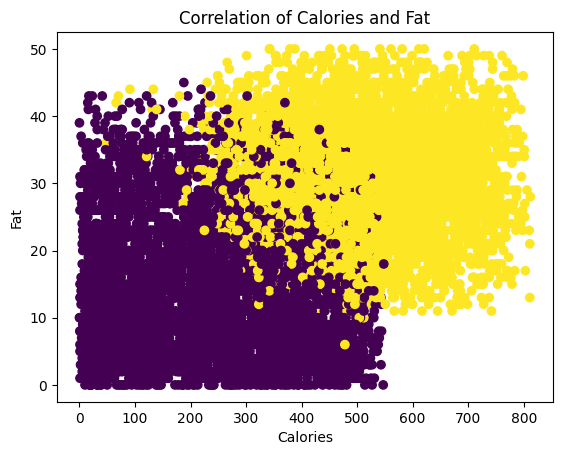

In [ ]:
# Visualization
df_pd = prediction.toPandas()
plt.scatter(
    df_pd["calories"],
    df_pd["fat"],
    c = df_pd["prediction"]
)
plt.xlabel("Calories")
plt.ylabel("Fat")
plt.title("Correlation of Calories and Fat")
plt.show()

In [ ]:
df.show()

+-----------+--------+------+----+----------+--------------------+--------------------+
|sugar_level|calories|weight| fat|food_color|           VectorOut|            features|
+-----------+--------+------+----+----------+--------------------+--------------------+
|      145.0|   764.0|1745.0|46.0|         4|[145.0,764.0,1745...|[3.16585848810440...|
|        4.0|   262.0|1903.0|24.0|         5|[4.0,262.0,1903.0...|[0.08733402725805...|
|       95.0|   448.0|1539.0|27.0|         9|[95.0,448.0,1539....|[2.07418314737874...|
|      100.0|   375.0| 746.0|11.0|         9|[100.0,375.0,746....|[2.18335068145131...|
|        8.0|    93.0| 134.0|26.0|         8|[8.0,93.0,134.0,2...|[0.17466805451610...|
|      140.0|   651.0|1989.0|24.0|         6|[140.0,651.0,1989...|[3.05669095403184...|
|       35.0|   331.0|1994.0|32.0|         5|[35.0,331.0,1994....|[0.76417273850796...|
|       35.0|   245.0| 438.0|28.0|         3|[35.0,245.0,438.0...|[0.76417273850796...|
|       59.0|   771.0|  31.0|24.